# US GDP Forecasting

Author: Dron Mongia

Course Project, UC Irvine, Math 10, S24

I would like to post my notebook on the course’s website: Yes

# Motivation and Procedure

GDP is a very strong metric of a country's economic wellbeing and therefore, forecasts of GDP are highly sought after. Policy makers and legislators, for example, may want to have a rough forecast of the trends regarding the country's GDP prior to passing some new bill or law. My procedure for this project will be to first compile time series data from the FRED api consisting of some economic metrics closely related to GDP (GDP = Consumption + Investment + Govt. Spending + Net Export). We then will conduct a series of exploratory tests to better understand our data, and finally we will use a vairety of models (including machine learning methods) to see which one provides the most accurate forecast.

In [1]:
import fredapi as fd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Feature Creation

In [2]:
fred = fd.Fred(api_key = 'efdb939ff3f6b3129c564ef0aa34a91e') # generally this should be hidden, however for the purposes of this project I will keep it visible

In [3]:
def gen_df(category, series):
    gen_ser = fred.get_series(series, frequency='q')
    return pd.DataFrame({'Date': gen_ser.index, category + ' : Billions of dollars': gen_ser.values})

In [4]:
def merge_dataframes(dataframes, on_column):
    merged_df = dataframes[0]

    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=on_column)

    return merged_df

In [5]:
dataframes_list = [
    gen_df('GDP', 'GDP'),
    gen_df('PCE', 'PCE'),
    gen_df('GPDI', 'GPDI'),
    gen_df('NETEXP', 'NETEXP'),
    gen_df('GovTotExp', 'W068RCQ027SBEA')
]

In [6]:
data = merge_dataframes(dataframes_list,'Date')
data

,Date,GDP : Billions of dollars,PCE : Billions of dollars,GPDI : Billions of dollars,NETEXP : Billions of dollars,GovTotExp : Billions of dollars
0,1960-01-01,542.648,326.4,96.476,2.858,144.233
1,1960-04-01,541.080,332.2,87.096,3.395,147.417
2,1960-07-01,545.604,332.1,86.377,4.682,150.459
3,1960-10-01,540.197,334.0,75.963,5.880,153.780
4,1961-01-01,545.018,334.5,78.378,5.902,157.254
...,...,...,...,...,...,...
252,2023-01-01,26813.601,18269.6,4725.828,-825.687,9326.383
253,2023-04-01,27063.012,18419.0,4780.290,-806.093,9422.404
254,2023-07-01,27610.128,18679.5,4915.033,-779.231,10007.677
255,2023-10-01,27956.998,18914.5,4954.426,-783.734,9700.808


In [7]:
Date_col = data['Date'].tail(26) # to be used later on
print(Date_col) 

231   2017-10-01
232   2018-01-01
233   2018-04-01
234   2018-07-01
235   2018-10-01
236   2019-01-01
237   2019-04-01
238   2019-07-01
239   2019-10-01
240   2020-01-01
241   2020-04-01
242   2020-07-01
243   2020-10-01
244   2021-01-01
245   2021-04-01
246   2021-07-01
247   2021-10-01
248   2022-01-01
249   2022-04-01
250   2022-07-01
251   2022-10-01
252   2023-01-01
253   2023-04-01
254   2023-07-01
255   2023-10-01
256   2024-01-01
Name: Date, dtype: datetime64[ns]


# EDA

Below is a simple line plot comparing each of the time series. We notice that some of the features resemble GDP far more than others, however, we can not yet begin selecting and removing certain features prior do conducting more exploratory tests.

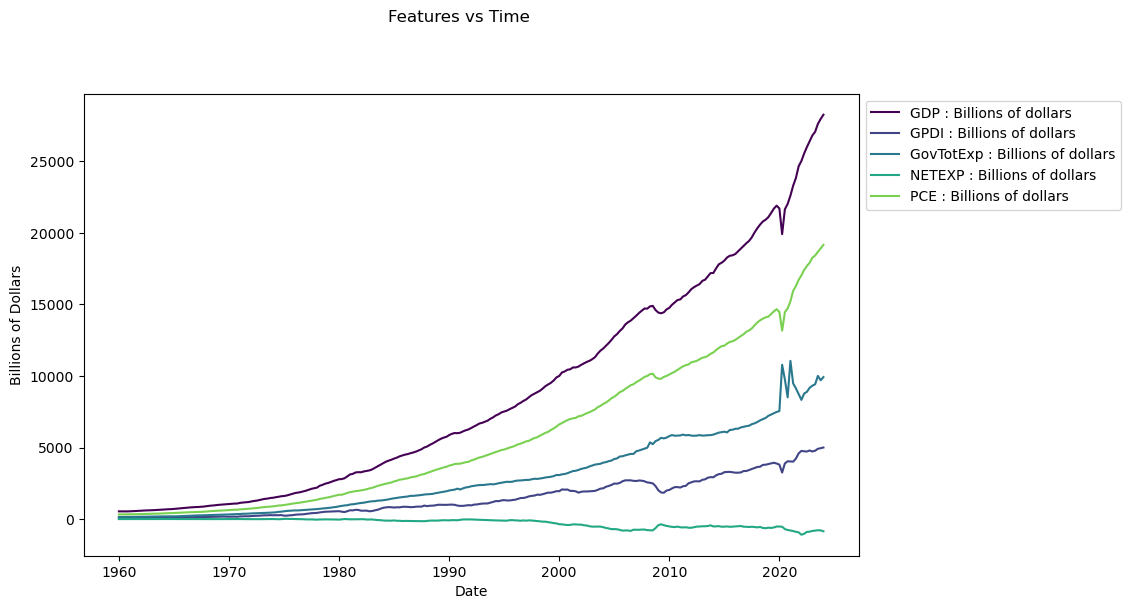

In [8]:
date_column = 'Date'

feature_columns = data.columns.difference([date_column])

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Features vs Time', y=1.02)

for i, feature in enumerate(feature_columns):
    ax.plot(data[date_column], data[feature], label=feature, color=plt.cm.viridis(i / len(feature_columns)))

ax.set_xlabel('Date')
ax.set_ylabel('Billions of Dollars')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


Here we run a test to evaluate the stationarity of out time series. Stationarity essentially means that a time series has a constant mean and varience. This is important to test for because many popular forecasting methods require stationarity to function properly. Although we can determine the stationarity for most of these time series just by looking at the graph, doing the testing is still beneficial because we will likely reuse it in later parts of the forecast.

In [9]:
from statsmodels.tsa.stattools import adfuller

for column in data.columns:
    if column != 'Date':
        result = adfuller(data[column])
        print(f"ADF Statistic for {column}: {result[0]}")
        print(f"P-value for {column}: {result[1]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"  {key}: {value}")

        print("\n" + "=" * 40 + "\n")

ADF Statistic for GDP : Billions of dollars: 7.301049607594838
P-value for GDP : Billions of dollars: 1.0
Critical Values:
  1%: -3.4562572510874396
  5%: -2.8729420379793598
  10%: -2.5728461399461744


ADF Statistic for PCE : Billions of dollars: 6.798336970342141
P-value for PCE : Billions of dollars: 1.0
Critical Values:
  1%: -3.4562572510874396
  5%: -2.8729420379793598
  10%: -2.5728461399461744


ADF Statistic for GPDI : Billions of dollars: 2.765116699661126
P-value for GPDI : Billions of dollars: 1.0
Critical Values:
  1%: -3.4561550092339512
  5%: -2.8728972266578676
  10%: -2.5728222369384763


ADF Statistic for NETEXP : Billions of dollars: -0.009808856906310032
P-value for NETEXP : Billions of dollars: 0.9577133440470131
Critical Values:
  1%: -3.4565688966099373
  5%: -2.8730786194395455
  10%: -2.5729189953388762


ADF Statistic for GovTotExp : Billions of dollars: 2.7291557866089486
P-value for GovTotExp : Billions of dollars: 0.9990880001645039
Critical Values:
  1%: 

The numbers we are interested from this test are the P-values. A P-value close to zero (equal to or less than 0.05) implies stationarity while a value closer to 1 implies nonstationarity. We can see that all of our time series are highly unstationary due to their statistically insignificant p-values, in other words we are unable to reject the null hypothesis for stationarity. Below is a simple visual representation of the test. The red dotted line represents the P-value where we would be able to determine stationarity for the time series, the blue box represents the P-value where we are at currently.

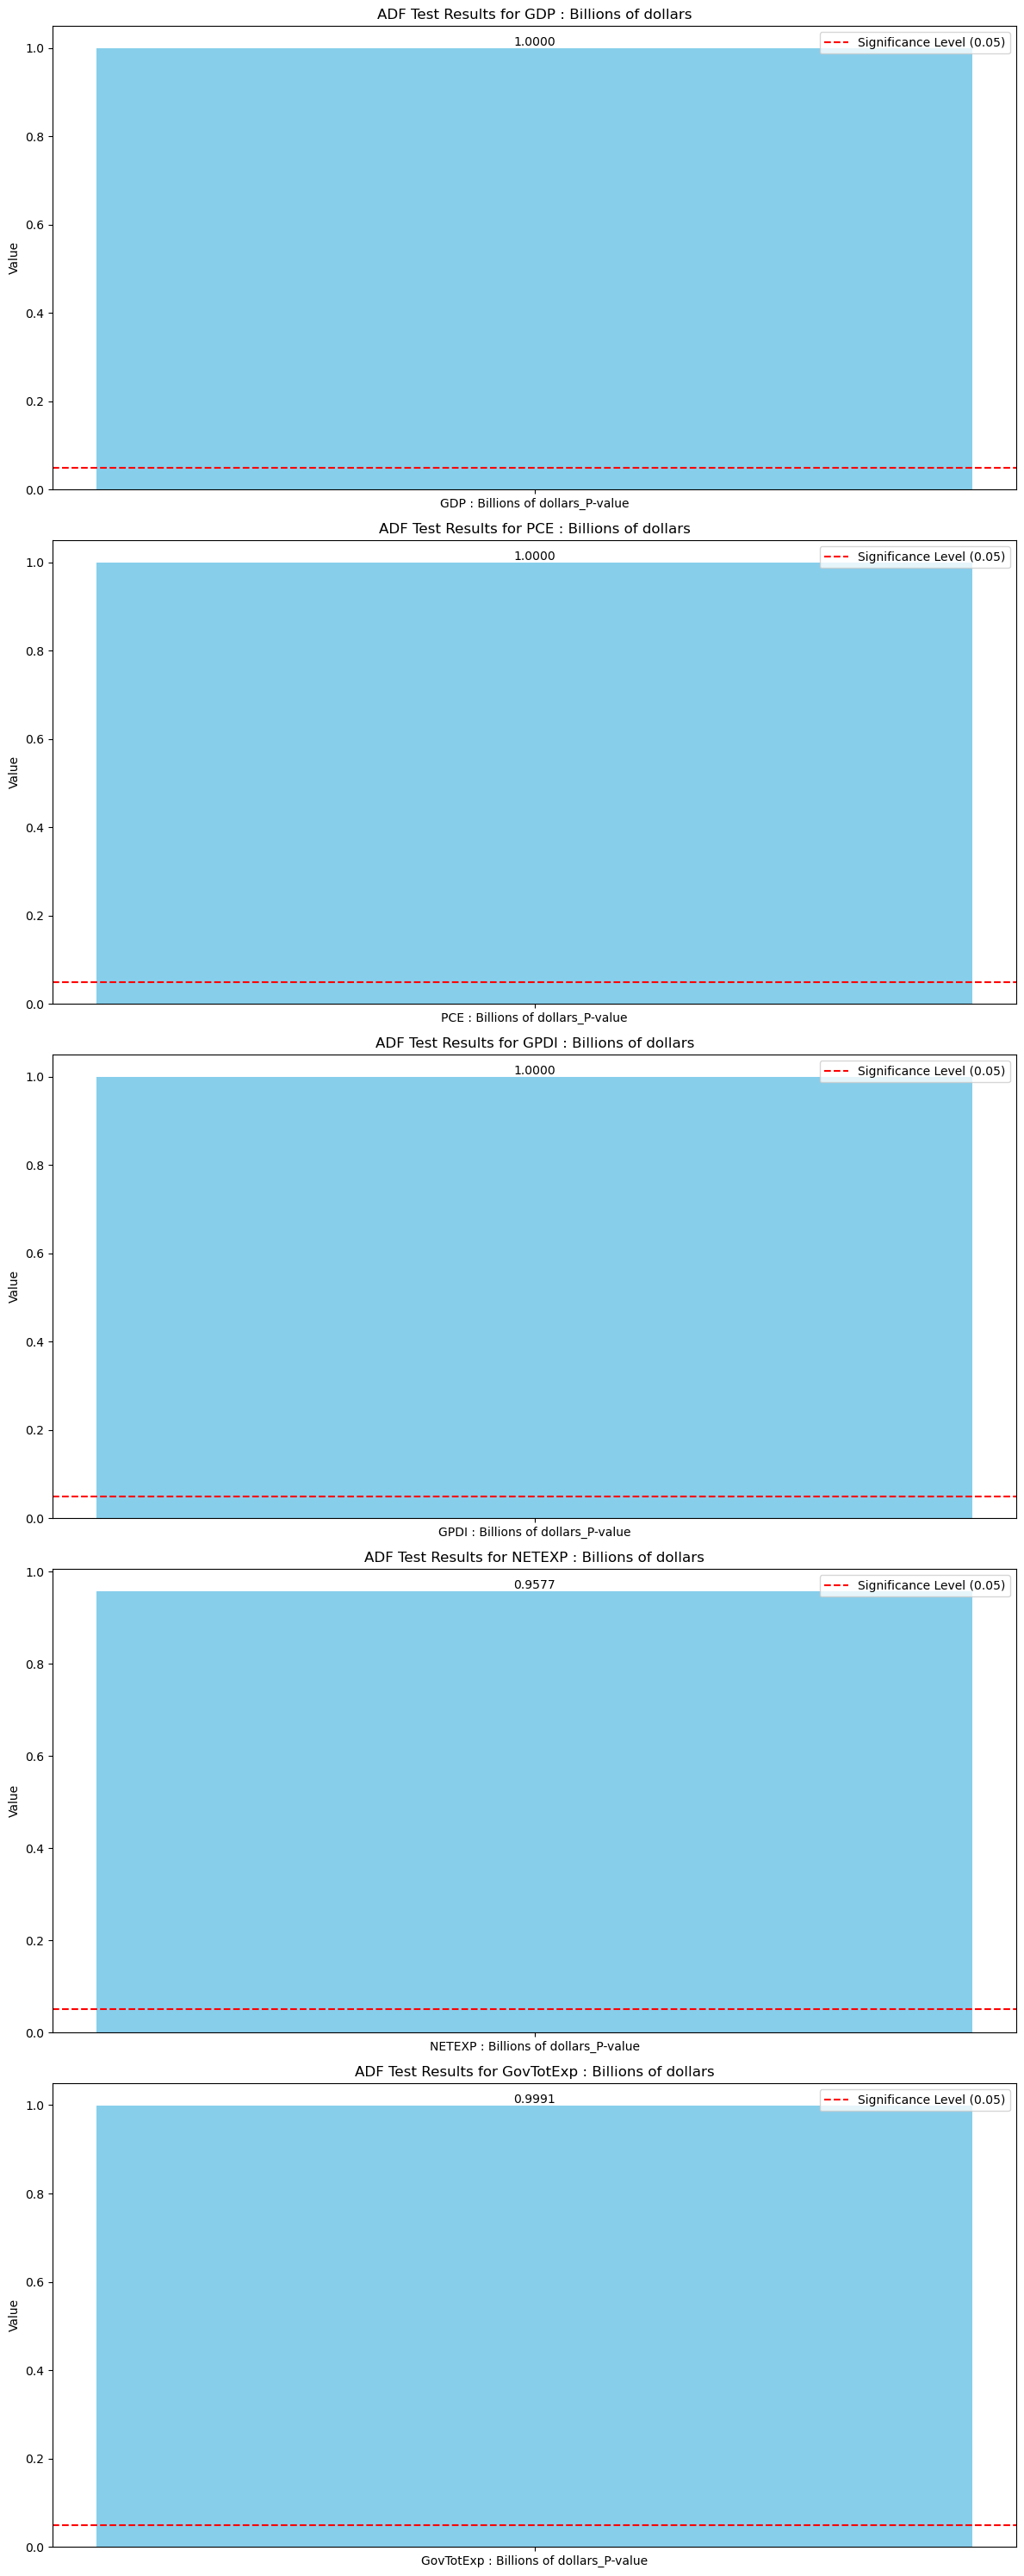

In [10]:

adf_results = []

for column in data.columns:
    if column != 'Date':  
        result = adfuller(data[column])
        adf_results.append({
            'Feature': column,
            'ADF Statistic': result[0],
            'P-value': result[1],
            'Critical Values': result[4]
        })

adf_df = pd.DataFrame(adf_results)

fig, axes = plt.subplots(nrows=len(adf_df), figsize=(12, 6 * len(adf_df)))

for idx, row in adf_df.iterrows():
    ax = axes[idx] if len(adf_df) > 1 else axes  

    ax.bar(row['Feature'] + '_P-value', row['P-value'], color='skyblue')
    ax.text(row['Feature'] + '_P-value', row['P-value'] + 0.005, f"{row['P-value']:.4f}", ha='center')
    
    ax.set_title(f'ADF Test Results for {row["Feature"]}')
    ax.set_ylabel('Value')
    ax.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    ax.legend()

plt.tight_layout()
plt.show()

Below is a VIF (variance inflation factor) test. The purpose is to check for multicollinearity, or the degree of correlation the predictors share with one another. High multicollineaity is not necessairly detrimental for our forecast, however, it can make it much harder for us to determine the individual effect of each feature time series for the prediction, thus hurting the interpretability of the model. Usually a score less than 5 implies no multicollinearity, implying that our features are extremely higly correlated with one another. This will play into our model selection for later.

C:\Users\Dronm\AppData\Local\Temp\ipykernel_49020\2334127177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                           Feature         VIF
0        PCE : Billions of dollars  170.028884
1       GPDI : Billions of dollars   77.277626
2     NETEXP : Billions of dollars    7.335556
3  GovTotExp : Billions of dollars   52.196119


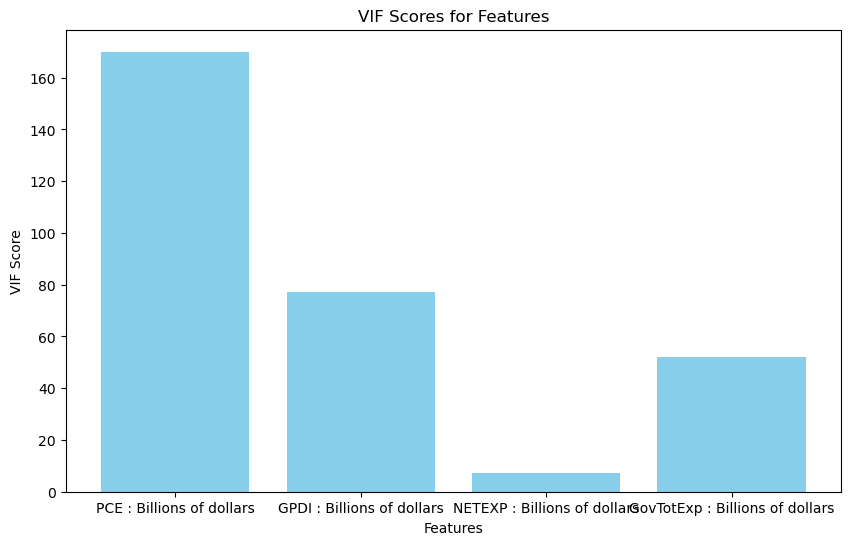

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = data.iloc[:, [2, 3, 4, 5]]
X['intercept'] = 1
X = X[['intercept'] + [col for col in X if col != 'intercept']]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns[1:] 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]

print(vif_data)
plt.figure(figsize=(10, 6))
plt.bar(vif_data["Feature"], vif_data["VIF"], color='skyblue')
plt.title('VIF Scores for Features')
plt.xlabel('Features')
plt.ylabel('VIF Score')
plt.show()

# Modeling

# VAR forecasting

To use the Vector Auto Regression (VAR) model we need to first ensure our data is stationary. we can achieve this using a technique called differencing which essentially is a tranformation of the raw data. It is defined mathematically as 
y'(t) = y(t)-y(t-1). We are taking values from our time series and calculating the change which occured following the previous point.

In [12]:
data_diff = data.drop('Date', axis=1).diff().dropna()
for column in data_diff.columns:
    result = adfuller(data_diff[column])
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"P-value for {column}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value}")

    print("\n" + "=" * 40 + "\n") 

ADF Statistic for GDP : Billions of dollars: -3.906538294382316
P-value for GDP : Billions of dollars: 0.0019872523174590214
Critical Values:
  1%: -3.4566744514553016
  5%: -2.8731248767783426
  10%: -2.5729436702592023


ADF Statistic for PCE : Billions of dollars: -6.0438368049790725
P-value for PCE : Billions of dollars: 1.3263283721705999e-07
Critical Values:
  1%: -3.4564641849494113
  5%: -2.873032730098417
  10%: -2.572894516864816


ADF Statistic for GPDI : Billions of dollars: -14.67874111897741
P-value for GPDI : Billions of dollars: 3.180913951450319e-27
Critical Values:
  1%: -3.4562572510874396
  5%: -2.8729420379793598
  10%: -2.5728461399461744


ADF Statistic for NETEXP : Billions of dollars: -8.837398948334888
P-value for NETEXP : Billions of dollars: 1.7044265762844e-14
Critical Values:
  1%: -3.4565688966099373
  5%: -2.8730786194395455
  10%: -2.5729189953388762


ADF Statistic for GovTotExp : Billions of dollars: -3.110199822877988
P-value for GovTotExp : Billions

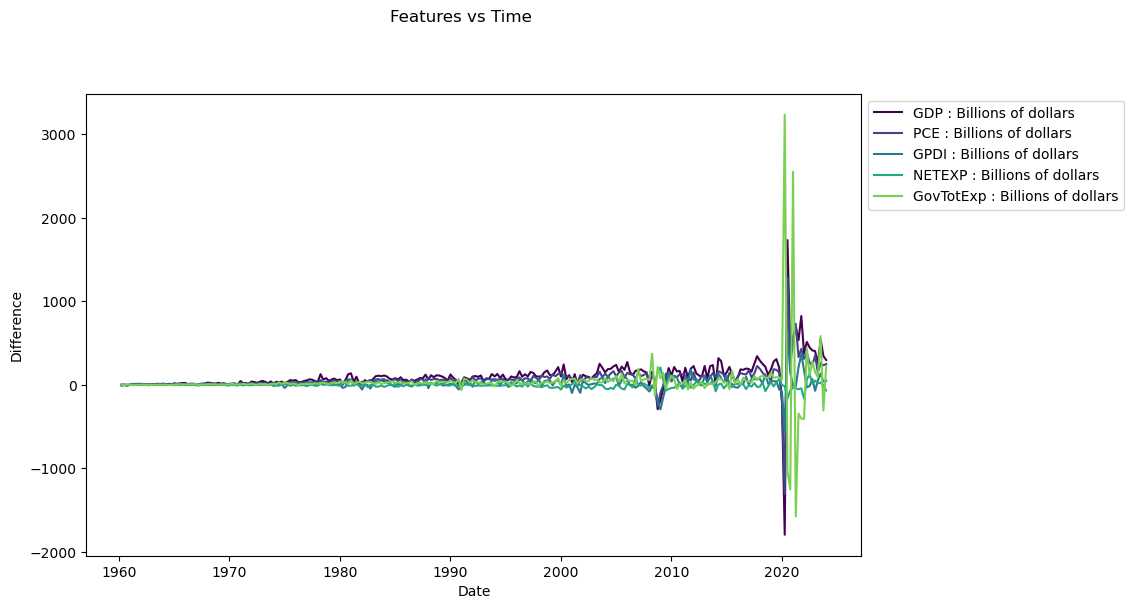

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Features vs Time', y=1.02)

for i, feature in enumerate(data_diff.columns):
    ax.plot(data['Date'][1:], data_diff[feature], label=feature, color=plt.cm.viridis(i / len(data_diff.columns)))

ax.set_xlabel('Date')
ax.set_ylabel('Difference')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

Below is an Autocorrelation Function (ACF) plot which tells us the significance that previous lags have to the current lag. This is usually helpful in evaluating factors like seasonality which are important for certain models. We can see that for the most part, previous lags have reasonably small scores in relation to our time series.

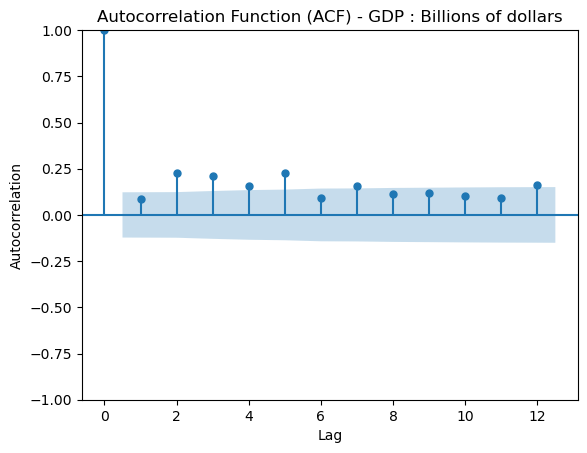

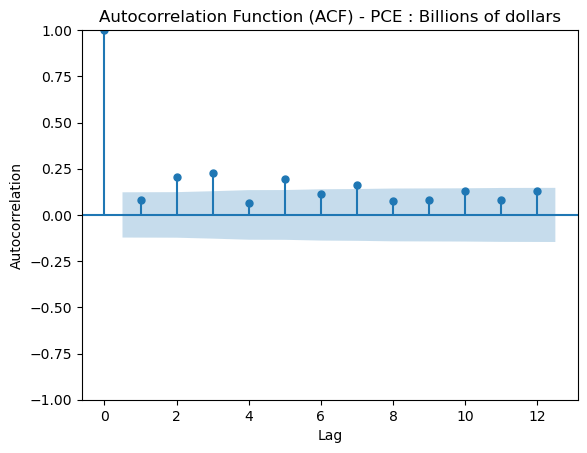

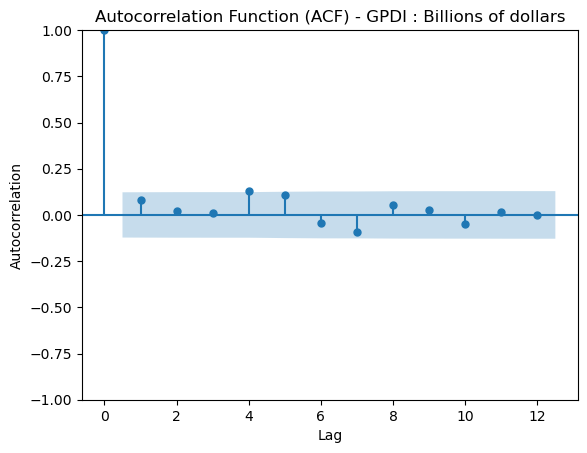

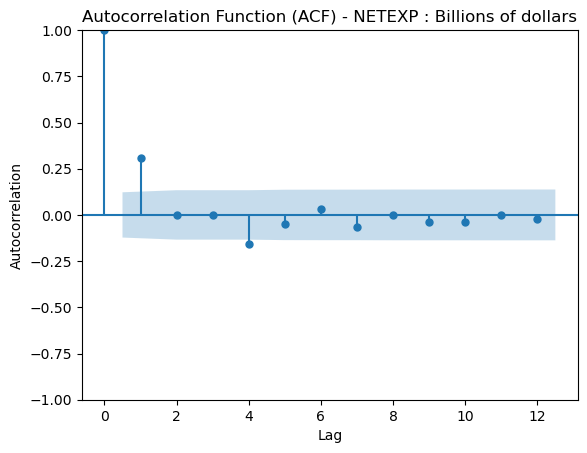

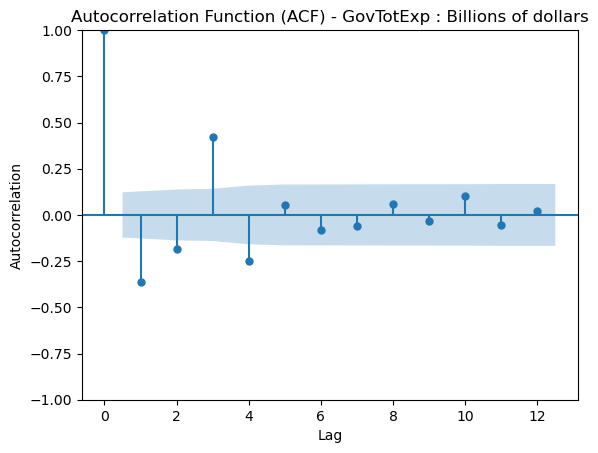

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

for column in data_diff.columns:
    if column != 'Date':  
        plot_acf(data_diff[column], lags=12)
        plt.title(f'Autocorrelation Function (ACF) - {column}')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()

From the ADF test along with the plot we can determine that our data is now centered around the mean. Our next step is to perform a granger causality test which indicates to us if a lagged verison of a specific time series can help us predict out target time series, however not necessairly that one time series causes the other.

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests
columns = ['PCE : Billions of dollars', 'GPDI : Billions of dollars', 'NETEXP : Billions of dollars', 'GovTotExp : Billions of dollars']
lags = [6, 9, 1, 1] #determined from individually testing each combination

for column, lag in zip(columns, lags):
    df_new = data_diff[['GDP : Billions of dollars', column]]
    print(f'For: {column}')
    gc_res = grangercausalitytests(df_new, lag)
    print("\n" + "=" * 40 + "\n")

For: PCE : Billions of dollars

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8821  , p=0.3485  , df_denom=252, df_num=1
ssr based chi2 test:   chi2=0.8926  , p=0.3448  , df=1
likelihood ratio test: chi2=0.8910  , p=0.3452  , df=1
parameter F test:         F=0.8821  , p=0.3485  , df_denom=252, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7486  , p=0.4741  , df_denom=249, df_num=2
ssr based chi2 test:   chi2=1.5273  , p=0.4660  , df=2
likelihood ratio test: chi2=1.5228  , p=0.4670  , df=2
parameter F test:         F=0.7486  , p=0.4741  , df_denom=249, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9103  , p=0.4366  , df_denom=246, df_num=3
ssr based chi2 test:   chi2=2.8087  , p=0.4221  , df=3
likelihood ratio test: chi2=2.7933  , p=0.4246  , df=3
parameter F test:         F=0.9103  , p=0.4366  , df_denom=246, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:

here we are just looking for a single lag for each feature which has statiscally significant p-values. Personal consumption Expenditures arguably did not make this cut off, however the sixth lag is so close that I decided to keep it in. Our next step is to create our VAR model now that we have decided that all of our features are significant. 

C:\Users\Dronm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE: 328.39
MAPE: 57.72%
GDP Actual vs Forecast:
          Date  Actual GDP  Forecasted GDP
231 2017-10-01     344.493       84.479946
232 2018-01-01     291.465      179.477634
233 2018-04-01     252.359      155.624087
234 2018-07-01     217.818      105.220413
235 2018-10-01     119.137      153.221441
236 2019-01-01     186.266      240.780124
237 2019-04-01     280.642      216.362075
238 2019-07-01     309.507      151.012279
239 2019-10-01     208.108      286.572411
240 2020-01-01    -195.877      232.309027
241 2020-04-01   -1793.370      226.008422
242 2020-07-01    1734.497      242.669525
243 2020-10-01     376.862      255.241138
244 2021-01-01     575.683      203.352525
245 2021-04-01     692.177      247.383534
246 2021-07-01     536.611      211.806723
247 2021-10-01     825.630      188.329785
248 2022-01-01     374.513      193.401142
249 2022-04-01     515.157      220.097723
250 2022-07-01     450.366      193.285245
251 2022-10-01     413.766      200.739952
252 2

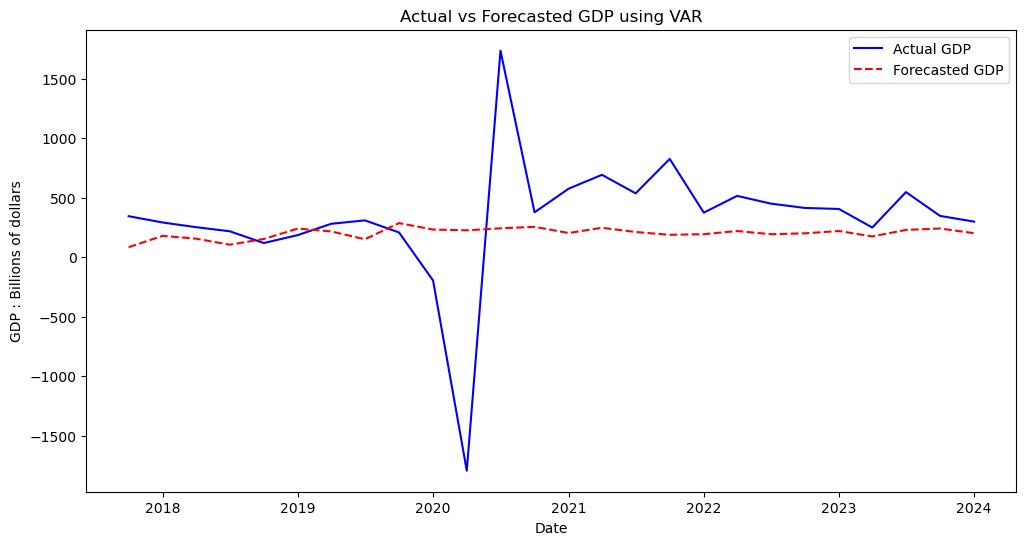

In [16]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
columns = ['GDP : Billions of dollars', 'PCE : Billions of dollars', 'GPDI : Billions of dollars', 'NETEXP : Billions of dollars', 'GovTotExp : Billions of dollars']
data_diff = data_diff[columns]

split_index = int(len(data_diff) * 0.90)
train_data = data_diff.iloc[:split_index]
test_data = data_diff.iloc[split_index:]

model = VAR(train_data)
results = model.fit(maxlags=14)

forecast_steps = len(test_data)
forecast = results.forecast(train_data.values[-results.k_ar:], steps=forecast_steps)


forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=columns)


gdp_forecast = forecast_df['GDP : Billions of dollars']
gdp_actual = test_data['GDP : Billions of dollars']


dates = data_diff.index[split_index:]


comparison_df = pd.DataFrame({'Date': Date_col, 'Actual GDP': gdp_actual.values, 'Forecasted GDP': gdp_forecast.values})
comparison_df.dropna(inplace=True)


mae = mean_absolute_error(comparison_df['Actual GDP'], comparison_df['Forecasted GDP'])
print(f"MAE: {mae:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(comparison_df['Actual GDP'], comparison_df['Forecasted GDP'])
print(f"MAPE: {mape:.2f}%")


print("GDP Actual vs Forecast:")
print(comparison_df)

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual GDP'], label='Actual GDP', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Forecasted GDP'], label='Forecasted GDP', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('GDP : Billions of dollars')
plt.title('Actual vs Forecasted GDP using VAR')
plt.legend()
plt.show()

Looking this forecast, we can clealy see that despite missing the mark quite heavily on both evaluation metrics used (MAE and MAPE), our model visually was not too innaccurate barring the outliers caused by the pandemic. We managed to stay on the testing line for the most part from 2018-2019 and from 2022-2024, however the global events following obviously threw in some unpredictability which affected the model's ability to precisely judge the trends.

# VECM forecasting

VECM (Vector Error Correction Model) is similar to, albeit a few key differences. Unlike VAR, VECM does not rely on stationarity so differencing and normalizing the time series will not be necessary. Below is a Johansen cointegration test which conpares test values to critical values in order to determine the number of relevant cointegration relationships (variables which share a long term equilibrium relationship).

In [17]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
columns = ['GDP : Billions of dollars', 'PCE : Billions of dollars', 'GPDI : Billions of dollars', 'NETEXP : Billions of dollars', 'GovTotExp : Billions of dollars']
data = data[columns]
rank_test = select_coint_rank(data, det_order=0, k_ar_diff=1)
print(rank_test.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          243.6          69.82
  1   5          94.27          47.85
  2   5          47.34          29.80
  3   5          15.06          15.49
-------------------------------------


MAE: 1482.53
GDP Actual vs Forecast:
          Date  Actual GDP  Forecasted GDP
231 2017-10-01   20037.088    19753.822655
232 2018-01-01   20328.553    19886.303817
233 2018-04-01   20580.912    20019.396912
234 2018-07-01   20798.730    20091.444369
235 2018-10-01   20917.867    20201.747583
236 2019-01-01   21104.133    20397.007183
237 2019-04-01   21384.775    20590.328595
238 2019-07-01   21694.282    20715.361432
239 2019-10-01   21902.390    20933.376095
240 2020-01-01   21706.513    21102.670722
241 2020-04-01   19913.143    21333.003367
242 2020-07-01   21647.640    21572.994781
243 2020-10-01   22024.502    21812.328621
244 2021-01-01   22600.185    22030.977990
245 2021-04-01   23292.362    22299.984264
246 2021-07-01   23828.973    22534.530745
247 2021-10-01   24654.603    22750.677701
248 2022-01-01   25029.116    22985.403756
249 2022-04-01   25544.273    23271.176604
250 2022-07-01   25994.639    23483.148023
251 2022-10-01   26408.405    23719.922245
252 2023-01-01   

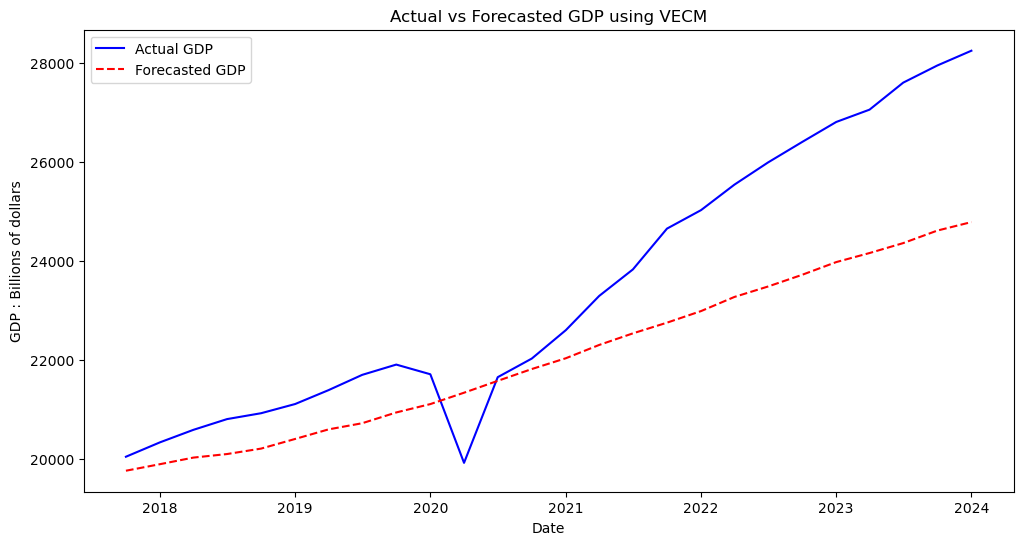

In [18]:
columns = ['GDP : Billions of dollars', 'PCE : Billions of dollars', 'GPDI : Billions of dollars', 'NETEXP : Billions of dollars', 'GovTotExp : Billions of dollars']
data = data[columns]
split_index1 = int(len(data) * 0.90)
train_data1 = data.iloc[:split_index1]
test_data1 = data.iloc[split_index1:]
rank_test = select_coint_rank(data, det_order=0, k_ar_diff=1)
lag_order = select_order(data, maxlags=15, deterministic="ci")

model = VECM(train_data1, k_ar_diff=lag_order.aic, coint_rank=rank_test.rank, deterministic='ci')
results = model.fit()

forecast_steps = len(test_data1)
forecast = results.predict(steps=forecast_steps)

forecast_df = pd.DataFrame(forecast, index=test_data1.index, columns=columns)

gdp_forecast = forecast_df['GDP : Billions of dollars']
gdp_actual = test_data1['GDP : Billions of dollars']

dates = dates[:len(gdp_actual)]

comparison_df = pd.DataFrame({'Date': Date_col, 'Actual GDP': gdp_actual.values, 'Forecasted GDP': gdp_forecast.values})
comparison_df.dropna(inplace=True)

mae = mean_absolute_error(comparison_df['Actual GDP'], comparison_df['Forecasted GDP'])
print(f"MAE: {mae:.2f}")

print("GDP Actual vs Forecast:")
print(comparison_df)

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual GDP'], label='Actual GDP', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Forecasted GDP'], label='Forecasted GDP', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('GDP : Billions of dollars')
plt.title('Actual vs Forecasted GDP using VECM')
plt.legend()
plt.show()

Though it is hard to compare to our VAR model to this one given that we are now using the unstationary data, we can still deduce both by the error metric and the visualization that this model was not able to accurately capture the trends in this forecast. With this, it is fair to say that we can rule out traditional statistical methods for approaching this problem.

# Machine Learning forecasting

When deciding a machine learning approach to model this problem, I wanted to keep in mind the amount of data that I am working with. Prior to creating lagged columns, out dataset has a total of 1275 observations across all time series. This means that using more complex approaches, such as LSTMs or gradient boosting, are perhaps unnecessary as we can use more simple model to recieve the same amount of accuracy and far more interpretability.  

In [19]:
def printevals(y_test,y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape:.2f}%")
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.2f}")
def plotresults(title):
    
    comparison_df = pd.DataFrame({'Date': Date_col, 'Actual GDP': y_test.values, 'Forecasted GDP': y_pred})
    comparison_df.dropna(inplace=True)

    print("GDP Actual vs Forecast:")
    print(comparison_df)
    
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Date'], comparison_df['Actual GDP'], label='Actual GDP', color='blue')
    plt.plot(comparison_df['Date'], comparison_df['Forecasted GDP'], label='Forecasted GDP', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('GDP : Billions of dollars')
    plt.title(title)
    plt.legend()
    plt.show()

# Train-Test Split 

Train-test splits for time series problems differ slightly from splits in traditional regression or classification tasks. Here it is imparative that we do not shuffle around our data, since that would mean we are training our model on data from the future which in turn will cause data leakages. Also notice that we are training over a very large portion (90%) of the data. This is because we are not actually concerned with forecasting over a large time frame. Realistically even forecasting over several years is not probable for this task. (Note we also used the train test split in our VAR and VECM models, it just felt more appropriate to talk about in the Machine Learning section)

In [20]:

split_index = int(len(data_diff) * 0.90)

train_data = data_diff.iloc[:split_index]
test_data = data_diff.iloc[split_index:]

X_train = train_data.drop('GDP : Billions of dollars', axis=1)
y_train = train_data['GDP : Billions of dollars']
X_test = test_data.drop('GDP : Billions of dollars', axis=1)
y_test = test_data['GDP : Billions of dollars']

# Random Forests

Remembering our VIF test from earlier, we know our features are highly multicolinear. This partially plays into the decision of choosing random forests as our model. decision trees make binary choices between features, meaning that theoretically our features being highly correlated should not be detrimental to our model. In addition to this, random forests is generally a very strong model being robust to overfitting from the schocastic nature of how the trees are computed and generally being very simple to implement.

MAPE: 44.31%
MAE: 287.97
GDP Actual vs Forecast:
          Date  Actual GDP  Forecasted GDP
231 2017-10-01     344.493       222.66964
232 2018-01-01     291.465       232.99618
233 2018-04-01     252.359       192.05078
234 2018-07-01     217.818       220.23716
235 2018-10-01     119.137       118.40956
236 2019-01-01     186.266       115.82722
237 2019-04-01     280.642       198.88359
238 2019-07-01     309.507       228.12818
239 2019-10-01     208.108       156.30033
240 2020-01-01    -195.877       -78.69897
241 2020-04-01   -1793.370      -161.98572
242 2020-07-01    1734.497       233.81564
243 2020-10-01     376.862       233.81564
244 2021-01-01     575.683       151.72623
245 2021-04-01     692.177       129.98664
246 2021-07-01     536.611       233.97176
247 2021-10-01     825.630       235.97884
248 2022-01-01     374.513       233.81564
249 2022-04-01     515.157       163.32067
250 2022-07-01     450.366       167.84568
251 2022-10-01     413.766       275.92276
252 2

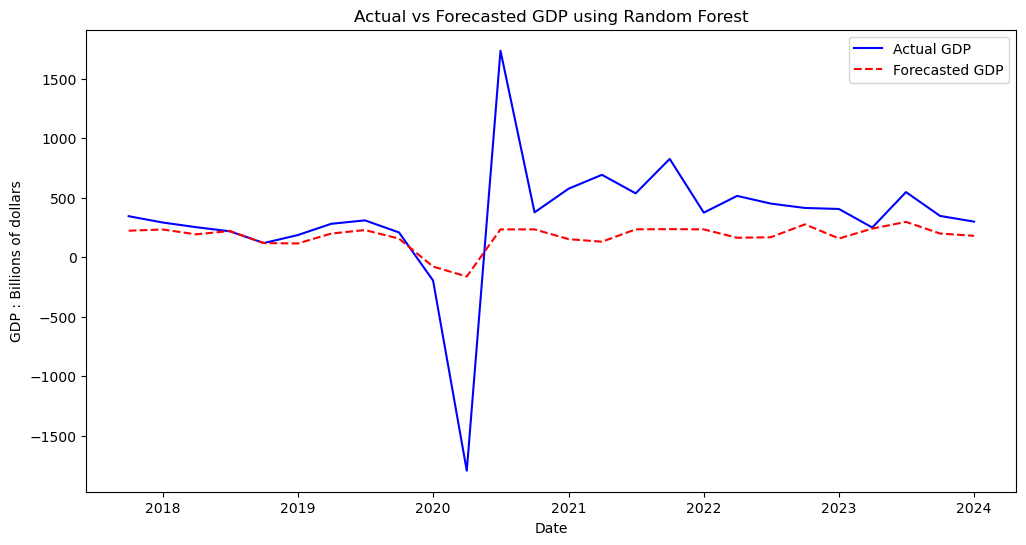

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

printevals(y_test,y_pred)
plotresults('Actual vs Forecasted GDP using Random Forest')

We can see that Random Forests was able to produce our best forecast yet, attaining better error metrics than our attepts at VAR and VECM. Perhaps most impressively, visually we can see that our model was almost perfectly encaptualiting the data from 2017-2019, just prior to encountering the outliers. 

# KNN

KNN (K-Nearest-Neighbors) was one final apporach I wanted to attempt. Given that our data is fairly low dimensional (5 features), with over 1000 observations, we have a ratio which should allow this algorithm to perform very well. Notice below we test out various values of our hyperparamter k, with k=2 seemingly being the best one.

In [22]:
from sklearn.neighbors import KNeighborsRegressor
for i in range (1,10):
    knn_model = KNeighborsRegressor(n_neighbors=i)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)

    print(f'for k = {i} ')
    printevals(y_test,y_pred)
    print("\n" + "=" * 40 + "\n")

for k = 1 
MAPE: 48.93%
MAE: 302.74


for k = 2 
MAPE: 47.72%
MAE: 303.45


for k = 3 
MAPE: 48.31%
MAE: 306.37


for k = 4 
MAPE: 48.41%
MAE: 306.15


for k = 5 
MAPE: 49.35%
MAE: 310.94


for k = 6 
MAPE: 50.54%
MAE: 315.49


for k = 7 
MAPE: 50.36%
MAE: 315.71


for k = 8 
MAPE: 50.62%
MAE: 317.13


for k = 9 
MAPE: 50.04%
MAE: 315.95




MAPE: 47.72%
MAE: 303.45
GDP Actual vs Forecast:
          Date  Actual GDP  Forecasted GDP
231 2017-10-01     344.493        237.9050
232 2018-01-01     291.465        252.8530
233 2018-04-01     252.359        217.4445
234 2018-07-01     217.818        206.1615
235 2018-10-01     119.137        115.1375
236 2019-01-01     186.266        110.2265
237 2019-04-01     280.642        203.0175
238 2019-07-01     309.507        264.4540
239 2019-10-01     208.108        156.4880
240 2020-01-01    -195.877          1.0515
241 2020-04-01   -1793.370        -65.8135
242 2020-07-01    1734.497        227.1580
243 2020-10-01     376.862        129.9220
244 2021-01-01     575.683        167.6270
245 2021-04-01     692.177        124.7765
246 2021-07-01     536.611        227.1580
247 2021-10-01     825.630        227.1580
248 2022-01-01     374.513        193.9800
249 2022-04-01     515.157        167.6270
250 2022-07-01     450.366        185.8210
251 2022-10-01     413.766        167.6270
252 2

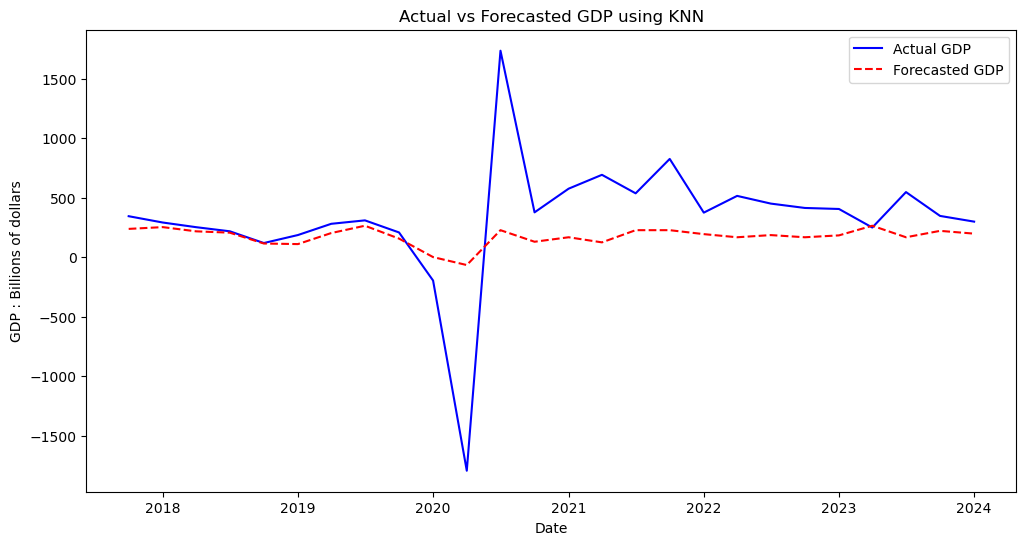

In [23]:
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

printevals(y_test,y_pred)

plotresults('Actual vs Forecasted GDP using KNN')

We can see KNN in its own right performed very well. Despite being out performed slightly in terms of error metrics compared to Random Forests, visually the model performed about the same and arguably captured the period before the pandemic from 2018-2019 even better than Random Forests. 

# Conclusions

Looking at all of our models, we can see the one which performed the best was Random Forests. This is most likely due to Random Forests generally being a very strong predictive model which can be fit to a vairety of datasets. In general the machine learning algorithms far outperformed the traditional statistical methods. Perhaps this can be explained by the fact that VAR and VECM both require a great amount of historical background data to work optimally, something which we did not have much of given that our data came out in quarterly intervals. There also may be something to be said about how both the machine learning models used were nonparametric. These models often are governed by less assumptions than their counterparts and therefore may be more flexible to unique problem sets like the one here. Below is our final best prediction, removing the differencing transformation we previously used to fit the models.

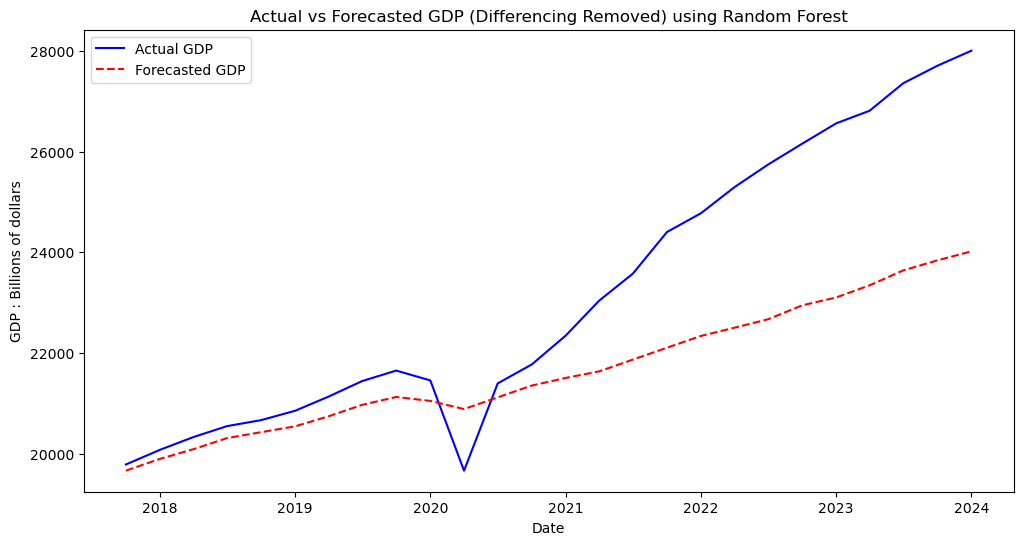

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

comparison_df = pd.DataFrame({'Date': Date_col, 'Actual GDP': y_test.values, 'Forecasted GDP': y_pred})
comparison_df.dropna(inplace=True)

last_actual_value = data.iloc[split_index - 1]['GDP : Billions of dollars']

comparison_df['Actual GDP'] = comparison_df['Actual GDP'].cumsum() + last_actual_value
comparison_df['Forecasted GDP'] = comparison_df['Forecasted GDP'].cumsum() + last_actual_value
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual GDP'], label='Actual GDP', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Forecasted GDP'], label='Forecasted GDP', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('GDP : Billions of dollars')
plt.title('Actual vs Forecasted GDP (Differencing Removed) using Random Forest')
plt.legend()
plt.show()

# Challenges and Areas of Improvement

By far the greatest challenge regarding this forecasting problem was handeling the massive outlier caused by the pandemic along with the following instability caused by it. Our methods for forecasting obviously can not predict that this would occur, ultimately decreasing our accuracy for each approach. Had our goal been to forecast the previous decade, our models would most likely have a much easier time finding and predicting trends. In terms of improvement and further research, I think a possible solution would be to perform some sort of normalization and outlier smoothing technique on the time interval from 2020-2024, and then evaluating our fully trained model on new quarterly data which comes in. In addition, it may be beneficial to incorporate new features which have a heavy influence on GDP such as quarterly inflation and personal assest evaluations.

# References

For traditional statistical methods - https://link.springer.com/book/10.1007/978-1-4842-7150-6
For machine learning methods - https://www.statlearning.com/